In [48]:
import pandas as pd
import numpy as np
import math
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import shortest_path as sp
import sc_pca
import random
import check_coords
import json

# dir = "/Users/ozgun/Data/Josh/"
dir = "/home/ozgunbabur/Data/Josh/"
data_file = dir + "normalized_mat.tsv"
data_file_denoised = dir + "normalized_denoised_mat.tsv"
pca_pre_file = dir + "pca_coords_8.tsv"
pca_file = dir + "pca_8.tsv"
pca_pre_file_2D = dir + "pca_coords_2.tsv"
pca_file_2D = dir + "pca_2.tsv"
umap_coords = dir + "umap_coords.tsv"
umap_file = dir + "umap.tsv"
dist_euc_file = dir + "dist_euclidean.tsv"
dist_cos_file = dir + "dist_cosine.tsv"
dist_cos_asis_file = dir + "dist_cosine_asis.tsv"
dist_um_file = dir + "dist_umap.tsv"
diffexp_file = dir + "diffexp_cosine.tsv"
metadata_file = dir + "meta_data.tsv"
def load_list(input_path):
    with open(input_path, 'rb') as fp:
        the_list = json.load(fp)
        return the_list


def load_luminal():
    return load_list(dir + "cells-luminal.json")


def load_basal():
    return load_list(dir + "cells-basal.json")

def get_color_string(val):
    # red = 1
    # green = 1 - val
    # blue = green
    # hex_col = mc.to_hex([red, green, blue])
    hex_col = mc.to_hex([1-val, 1-val, 1-val])
    # print("val = " + str(val) + " hex: " + hex_col)
    return hex_col

def get_distance_color(val, max_dist):
    if val > max_dist:
        return "0 0 0"
    else:
        rat = val / max_dist
        v = 255 - round(255 * rat)
        return str(v) + " " + str(v) + " " + str(v)

def write_traj_graph(trajs, source_list, target_list, distF, out_path, top_k):
    freq_map = {}

    for traj in trajs:
        for i in range(1, len(traj)-2):
            tup = (traj[i], traj[i+1])
            if tup in freq_map:
                freq_map[tup] = freq_map[tup] + 1
            else:
                freq_map[tup] = 1

    sor_f = sorted(freq_map, key=freq_map.get, reverse=True)
    limit = min(top_k, len(sor_f))

    mat = distF.to_numpy()
    cells = distF.columns.values.tolist()

    source_color = "255 255 200"
    target_color = "255 200 200"

    f_sif = open(out_path + ".sif", "w")
    f_fmt = open(out_path + ".format", "w")
    f_fmt.write("edge\tall-edges\twidth\t2\n")

    included_tup = []
    included_cell = []

    max_d = 0

    edge = "controls-state-change-of"
    for i in range(limit):
        src = sor_f[i][0]
        trg = sor_f[i][1]
        f_sif.write(src + "\t" + edge + "\t" + trg + "\n")
        src_ind = cells.index(src)
        trg_ind = cells.index(trg)
        d = math.sqrt(mat[src_ind, trg_ind])

        if d > max_d:
            max_d = d

        included_tup.append(sor_f[i])
        included_cell.append(src)
        included_cell.append(trg)

    for cell in included_cell:
        if cell in source_list:
            f_fmt.write("node\t" + cell + "\tcolor\t" + source_color + "\n")
        if cell in target_list:
            f_fmt.write("node\t" + cell + "\tcolor\t" + target_color + "\n")

    for tup in included_tup:
        src = tup[0]
        trg = tup[1]
        src_ind = cells.index(src)
        trg_ind = cells.index(trg)
        d = math.sqrt(mat[src_ind, trg_ind])
        col = get_distance_color(d, max_d)
        f_fmt.write("edge\t" + src + " " + edge + " " + trg + "\tcolor\t" + col + "\n")


    f_sif.close()
    f_fmt.close()


In [2]:
distF_cosine = pd.read_table(dist_cos_asis_file, index_col=0)
distF_euc = pd.read_table(dist_euc_file, index_col=0)
distF_um = pd.read_table(dist_um_file, index_col=0)

In [55]:
luminal_cells = load_luminal()
basal_cells = load_basal()
trajs_cos = sp.get_trajs_from_dataframe(distF_cosine, luminal_cells, basal_cells)

print(len(trajs_cos))
dens = sp.get_cell_density_of_trajs(trajs_cos)
print(len(dens))

table = pd.read_table(umap_file, index_col=0)
mat = table.to_numpy()

40000
578


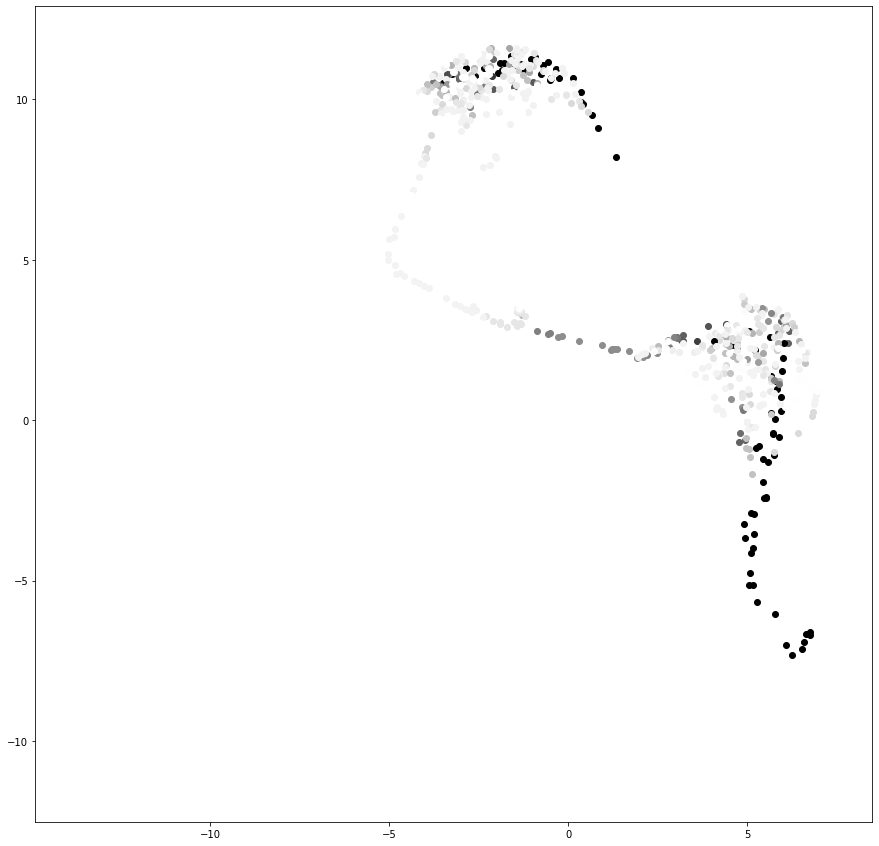

In [56]:
plt.figure(figsize=(15, 15))
ax = plt.axes()
ax.scatter(mat[0], mat[1], color = 'k', alpha=0.001)

# for cell in luminal_cells:
#     ax.scatter([table[cell][0]], [table[cell][1]], color='y', alpha=0.5)
# for cell in basal_cells:
#     ax.scatter([table[cell][0]], [table[cell][1]], color='y', alpha=0.5)

for key, value in dens.items():
    ax.scatter([table[key][0]], [table[key][1]], color=get_color_string(min(value * 10, 1)), alpha=1)

plt.show()

In [58]:
write_traj_graph(trajs_cos, luminal_cells, basal_cells, distF_cosine, dir + "traj-graph-cos-100", 100)

In [22]:
print(dens)

{'midpoint_GTGGGTCCACCGAAAG-1': 0.01995, 'midpoint_CGACTTCGTTGAGTTC-1': 0.02495, 'midpoint_CCGTGGAAGATCGATA-1': 0.0247, 'midpoint_GAAGCAGAGAGTGAGA-1': 0.083825, 'midpoint_TCATTACCACATGGGA-1': 0.1626, 'midpoint_GTCTTCGTCACCTTAT-1': 0.207275, 'midpoint_GGGCACTTCATCATTC-1': 0.330025, 'midpoint_GACGTTAGTTGCGTTA-1': 0.910175, 'midpoint_CGATTGACAAAGGTGC-1': 0.9489, 'midpoint_CCAATCCCACGCATCG-1': 0.958725, 'midpoint_CGAGCACCATACAGCT-1': 0.6857, 'midpoint_CCTTCGATCCCTAACC-1': 0.6857, 'midpoint_GATCGATGTACCGCTG-1': 0.11405, 'midpoint_GCTCTGTTCAACCATG-1': 0.03965, 'midpoint_TCAACGACATCCCATC-1': 0.029775, 'midpoint_CCTTCCCAGCCGTCGT-1': 0.014875, 'midpoint_TGGTTAGAGCACACAG-1': 0.00495, 'midpoint_GACGGCTAGATGCGAC-1': 0.258275, 'midpoint_CACAGGCGTGTTCGAT-1': 0.2434, 'midpoint_TACACGAAGCGTAATA-1': 0.0945, 'midpoint_GTTCGGGAGTCTCAAC-1': 0.0647, 'midpoint_CCTTTCTTCCTTTACA-1': 0.054925, 'midpoint_AGCATACGTAGGAGTC-1': 0.049925, 'midpoint_TACTCATTCCTTCAAT-1': 0.03, 'midpoint_TTCTACAAGGATGGTC-1': 0.214175,